# Notebook to test and learn about the Ensemble GP (Experimental)

In [29]:
#import numpy as np
import autograd.numpy as np  # Thinly-wrapped numpy
from fvgp.ensemble_gp import EnsembleGP
from fvgp.ensemble_gp import hyperparameters
import matplotlib.pyplot as plt

# An ensemble GP means that we allow the prior to be a sum of Gaussian priors. That means we have to define a set of prior-mean and kernel functions
In our case we assume 2 GPs, and therefore 2 prior mean and kernel functions
Feel free to play with those mean functions. Prior mean functions can be any real function, but remember, kernel funcitons have to be positive semi-definite. In terms of test functions, we define here a 1d step function and eggholders function in 2d.

In [30]:
def step(x):
    i = np.where(x[:,0] < 0.0)
    r = np.zeros((len(x[:,0])))
    r[i] = 1.0
    return r + np.sin(5.0 * x[:,0])/50.0
def eggholder(x):
    x1 = x[:,0]
    x2 = x[:,1]
    term1 = -(x2 + 47.) * np.sin(np.sqrt(abs(x2 + x1/2.+47.)))
    term2 = -x1 * np.sin(np.sqrt(abs(x1-(x2+47.))))
    return term1 + term2

def mean_func1(obj,x,hyperparameters):
    return np.ones(len(x)) * hyperparameters[-1]

def mean_func2(obj,x,hyperparameters):
    return np.ones(len(x)) * hyperparameters[-1]

def kernel1(x1,x2,hps,obj):
    d = 0
    for i in range(len(x1[0])):
        #d += abs(np.subtract.outer(x1[:,i],x2[:,i]))
        a = np.array([x1[:,i],]*len(x2)).T
        b = np.array([x2[:,i],]*len(x1))
        d += abs(a-b) #+ 1e-6
    d = np.sqrt(d+1e-6)
    #return hps[0] * obj.exponential_kernel(d,hps[1])
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])

def kernel2(x1,x2,hps,obj):
    d = 0
    for i in range(len(x1[0])):
        #d += abs(np.subtract.outer(x1[:,i],x2[:,i]))
        a = np.array([x1[:,i],]*len(x2)).T
        b = np.array([x2[:,i],]*len(x1))
        d += abs(a-b) #+ 1e-6
    d = np.sqrt(d+1e-6)
    #return hps[0] * obj.exponential_kernel(d,hps[1])
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])

### For ensemble GPs, the hyperparameters are more complicated than for single GPs and therefore we define an extra object for the hyperparameters. That object keeps track of the structure of the hyperparameters vectorized and unvectorized

In [31]:
weights = np.ones(2) / 2.0   ####those are two weight for the two GPs
weights_bounds = np.array([[0.000001,1.0],[0.000001,1.0]]) ##those are the bounds we will use to optimize the weights
hps = [np.array([1e6,10000.0,1.]),np.array([1e6,10000.0,0.0])] ##here we have the hyperparameters: (in order)
                                                           ##GP1 signal variance, length scale, prior mean
                                                           ##same for GP2
hps_bounds = [np.array([[0.001,10000000.],[0.001,10000.],[-2000.0,2000.0]]),
              np.array([[0.001,10000000.],[0.001,10000.],[-2000.0,2000.0]])] ##those are bounds for training, same order
hps_obj = hyperparameters(weights,weights_bounds,hps,hps_bounds)  ##creating the hps obj instance

## ...creating some data...

(400, 2)


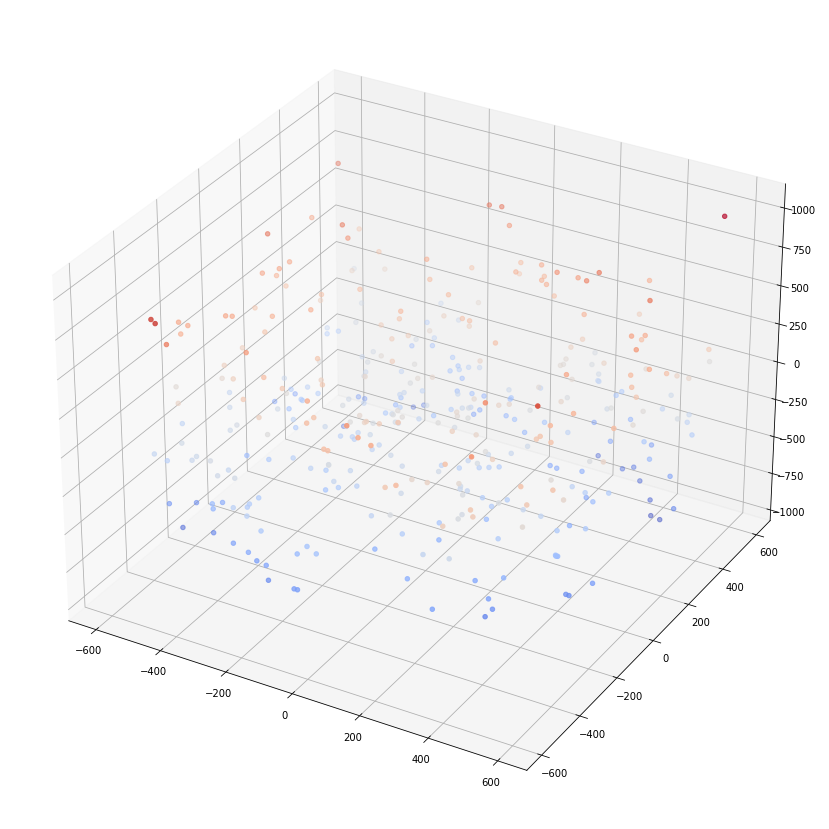

In [32]:
N = 400
points = np.empty((N,2))   ##needst two columns for eggholder
#points = np.random.uniform(low = -3, high = 3, size = points.shape) # for step function
points = np.random.uniform(low = -600, high = 600, size = points.shape) # for step function
#values = step(points)
values = eggholder(points)

print(points.shape)


#plt.scatter(points,values)


fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], values, c=values, cmap=plt.cm.coolwarm)

## ...initializing the ensemble GP and training it ... oh and checking some derivatives

In [33]:
print(hps_obj.vectorized_hps)


print(points.shape)
print(values.shape)
print(hps_obj.hps)

#the first parameter has to be "1" for the step function and "2" for eggholder
my_gp = EnsembleGP(2,points,values,2,hps_obj,variances = np.ones(values.shape) * 0.1,
                gp_kernel_functions = [kernel1,kernel2],
                gp_mean_functions = [mean_func1,mean_func2],
                compute_device = "cpu")
print("likelihood before training: ", my_gp.ensemble_log_likelihood(hps_obj.vectorized_hps))






[5.e-01 5.e-01 1.e+06 1.e+04 1.e+00 1.e+06 1.e+04 0.e+00]
(400, 2)
(400,)
[array([1.e+06, 1.e+04, 1.e+00]), array([1000000.,   10000.,       0.])]
likelihood before training:  88365079.61446764


In [35]:
my_gp.train(hps_obj,
                pop_size = 20,
                tolerance = 0.0001,
                max_iter = 10)

Ensemble fvGP submitted to global optimization
bounds are [[ 1.e-06  1.e+00]
 [ 1.e-06  1.e+00]
 [ 1.e-03  1.e+07]
 [ 1.e-03  1.e+04]
 [-2.e+03  2.e+03]
 [ 1.e-03  1.e+07]
 [ 1.e-03  1.e+04]
 [-2.e+03  2.e+03]]
maximum number of iterations:  10
termination tolerance:  0.0001
differential_evolution step 1: f(x)= 13399.8
differential_evolution step 2: f(x)= 3334.32
differential_evolution step 3: f(x)= 3334.32
differential_evolution step 4: f(x)= 3334.32
differential_evolution step 5: f(x)= 3113.2
differential_evolution step 6: f(x)= 2907.03
differential_evolution step 7: f(x)= 2907.03
differential_evolution step 8: f(x)= 2904.22
differential_evolution step 9: f(x)= 2904.22
differential_evolution step 10: f(x)= 2904.22
fvGP found weights  [0.4        0.59999487]
and hyperparameters:  [array([7.05713257e+06, 5.79373639e+01, 3.62723542e+02]), array([1.28311720e+06, 9.43823443e+02, 4.51138076e+01])]
 with likelihood:  2900.363238207367  via global optimization
new weights after training:  [0

In [36]:
#from autograd import jacobian
#from autograd import elementwise_grad as el



grad = my_gp.ensemble_log_likelihood_grad(hps_obj.vectorized_hps)
e = 1e-6
print(hps_obj.vectorized_hps)
for i in range(len(hps_obj.vectorized_hps)):
    v1 = np.array(hps_obj.vectorized_hps)
    v2 = np.array(hps_obj.vectorized_hps)
    v1[i] = v1[i] - e
    v2[i] = v2[i] + e
    #print(my_gp.ensemble_log_likelihood(v1))
    #print(my_gp.ensemble_log_likelihood(v2))
    g = (my_gp.ensemble_log_likelihood(v2) - my_gp.ensemble_log_likelihood(v1))/(2.*e)
    print("compare: ", g, grad[i])
    print("v1: ",v1[i]," v2: ",v2[i])
    #assert abs(grad[i] - g) < 0.01, "grad wrong"
print("grad: ",grad)
print("===========================")
print("gradient correctly computed")
print("===========================")


[4.00000000e-01 5.99994873e-01 7.05713257e+06 5.79373639e+01
 3.62723542e+02 1.28311720e+06 9.43823443e+02 4.51138076e+01]
compare:  -2.499999936844688 -2.5000000000000067
v1:  0.399998999999999  v2:  0.40000099999999894
compare:  0.0 -0.0
v1:  0.5999938729833241  v2:  0.5999958729833241
compare:  2.5011104298755527e-06 3.4212069296317887e-06
v1:  7057132.572075117  v2:  7057132.572077118
compare:  0.00047339199227280915 0.0004739334879033663
v1:  57.93736289472779  v2:  57.937364894727786
compare:  -8.640199666842818e-06 -8.459404358833467e-06
v1:  362.7235414891545  v2:  362.7235434891545
compare:  0.0 -0.0
v1:  1283117.2015754154  v2:  1283117.2015774155
compare:  0.0 0.0
v1:  943.823441652736  v2:  943.823443652736
compare:  0.0 -0.0
v1:  45.113806590268176  v2:  45.11380859026817
grad:  [-2.50000000e+00 -0.00000000e+00  3.42120693e-06  4.73933488e-04
 -8.45940436e-06 -0.00000000e+00  0.00000000e+00 -0.00000000e+00]
gradient correctly computed


## ...training asynchronously... 

In [37]:
import time
my_gp.train_async(hps_obj,
                pop_size = 20,
                tolerance = 0.0001,
                max_iter = 100000)

Ensemble fvGP submitted to HGDL optimization
bounds are [[ 1.e-06  1.e+00]
 [ 1.e-06  1.e+00]
 [ 1.e-03  1.e+07]
 [ 1.e-03  1.e+04]
 [-2.e+03  2.e+03]
 [ 1.e-03  1.e+07]
 [ 1.e-03  1.e+04]
 [-2.e+03  2.e+03]]
initial weights:  [4.00000000e-01 5.99994873e-01 7.05713257e+06 5.79373639e+01
 3.62723542e+02 1.28311720e+06 9.43823443e+02 4.51138076e+01]
HGDL starts with:  [[ 2.07514662e-01  1.82721578e-01  5.58009866e+06  2.39952526e+03
  -1.86901317e+03  1.13933576e+06  3.59177678e+03 -7.96914656e+02]
 [ 2.17542968e-01  7.07890411e-01  8.69917685e+06  2.18765669e+03
   1.66188423e+03  4.81115090e+06  4.85864687e+03 -1.00543063e+03]
 [ 8.79571133e-01  9.45061892e-01  7.23438639e+05  9.63584608e+03
  -2.50068297e+02  6.67802734e+06  4.15361082e+03 -1.73806004e+03]]


In [39]:
my_gp.update_hyperparameters()
print("current likelihood: ", my_gp.ensemble_log_likelihood(hps_obj.vectorized_hps))

new weights after training:  [1.00000e-06 9.99999e-01]
new hps     after training:  [array([4.43691445e+06, 5.59477587e+03, 5.56490296e+01]), array([1.22613796e+05, 7.29053227e+00, 2.01040257e+01])]
Ensemble fvGP async hyperparameter update successful
current likelihood:  2818.281948345136


In [40]:
my_gp.kill_training()
print("current likelihood: ", my_gp.ensemble_log_likelihood(hps_obj.vectorized_hps))

fvGP is killing asynchronous training....
HGDL kill initialized ...
HGDL kill successful
fvGP successfully killed the training.
current likelihood:  2818.281948345136


### I hope you saw how the Gaussian priors are places at 0 and 1, just like we would expect from the data.

## Depending on the randomly chosen data you might see that the result is not Gaussian
if you can't see it, run the notebook again

In [ ]:
import matplotlib.pyplot as plt
plot_n  = 1000
x_input = np.empty((plot_n,1))
x_input[:,0] = np.linspace(-2,2,plot_n)
y = func(x_input)
post = my_gp.posterior(x_input, res = 1000)
pdf = post["pdf"]

fig = plt.figure(figsize = (10,10))
plt.imshow((np.flip(np.array(pdf).T,axis = 0)),cmap=plt.cm.viridis)
plt.show()
mean1 = post["f(x)"][0]
mean2 = post["f(x)"][1]
cov1 = post["v(x)"][0]
cov2 = post["v(x)"][1]
plt.plot(np.linspace(-3,3,1000),mean1, label = "GP1")
plt.plot(np.linspace(-3,3,1000),mean2, label = "GP2")
plt.legend()
plt.fill_between(np.linspace(-3,3,1000),mean1 - 3.0 * np.sqrt(cov1), mean1 + 3.0 * np.sqrt(cov1), alpha=0.2)
plt.fill_between(np.linspace(-3,3,1000),mean2 - 3.0 * np.sqrt(cov2), mean2 + 3.0 * np.sqrt(cov2), alpha=0.2)
plt.scatter(points,values)

In [ ]:
import plotly.graph_objects as go
import numpy as np
def plot(x,y,z,data = None):
    fig = go.Figure()
    fig.add_trace(go.Surface(x = x, y = y,z=z))
    if data is not None: 
        fig.add_trace(go.Scatter3d(x=data[:,0], y=data[:,1], z=data[:,2],
                                   mode='markers'))

    fig.update_layout(title='Posterior Mean', autosize=True,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))


    fig.show()




import matplotlib.pyplot as plt
plot_n  = 50
x_pred = np.zeros((plot_n**2,2))
x = np.linspace(-600,600,plot_n)
y = np.linspace(-600,600,plot_n)
x,y = np.meshgrid(x,y)
counter = 0
for i in  range(plot_n):
    for j in range(plot_n):
        x_pred[counter] = np.array([x[i,j],y[i,j]])
        counter += 1
  
post = my_gp.posterior(x_pred, res = 1000)
pdf = post["pdf"]


mean1 = post["f(x)"][0].reshape(plot_n,plot_n)
mean2 = post["f(x)"][1].reshape(plot_n,plot_n)
cov1 = post["v(x)"][0].reshape(plot_n,plot_n)
cov2 = post["v(x)"][1].reshape(plot_n,plot_n)
plot(x,y,mean1)
plot(x,y,mean2)